In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import gutenberg, stopwords

## Intro to word2vec

The most common unsupervised neural network approach for NLP is word2vec, a shallow neural network model for converting words to vectors using distributed representation: Each word is represented by many neurons, and each neuron is involved in representing many words.  At the highest level of abstraction, word2vec assigns a vector of random values to each word.  For a word W, it looks at the words that are near W in the sentence, and shifts the values in the word vectors such that the vectors for words near that W are closer to the W vector, and vectors for words not near W are farther away from the W vector.  With a large enough corpus, this will eventually result in words that often appear together having vectors that are near one another, and words that rarely or never appear together having vectors that are far away from each other.  Then, using the vectors, similarity scores can be computed for each pair of words by taking the cosine of the vectors.  

This may sound quite similar to the Latent Semantic Analysis approach you just learned.  The conceptual difference is that LSA creates vector representations of sentences based on the words in them, while word2vec creates representations of individual words, based on the words around them.

## What is it good for?

Word2vec is useful for any time when computers need to parse requests written by humans. The problem with human communication is that there are so many different ways to communicate the same concept. It's easy for us, as humans, to know that "the silverware" and "the utensils" can refer to the same thing. Computers can't do that unless we teach them, and this can be a real chokepoint for human/computer interactions. If you've ever played a text adventure game (think _Colossal Cave Adventure_ or _Zork_), you may have encountered the following scenario:

And your brain explodes from frustration. A text adventure game that incorporates a properly trained word2vec model would have vectors for "pick up", "lift", and "take" that are close to the vector for "grab" and therefore could accept those other verbs as synonyms so you could move ahead faster. In more practical applications, word2vec and other similar algorithms are what help a search engine return the best results for your query and not just the ones that contain the exact words you used. In fact, search is a better example, because not only does the search engine need to understand your request, it also needs to match it to web pages that were _also written by humans_ and therefore _also use idiosyncratic language_.

Humans, man.  

So how does it work?

## Generating vectors: Multiple algorithms

In considering the relationship between a word and its surrounding words, word2vec has two options that are the inverse of one another:

 * _Continuous Bag of Words_ (CBOW): the identity of a word is predicted using the words near it in a sentence.
 * _Skip-gram_: The identities of words are predicted from the word they surround. Skip-gram seems to work better for larger corpuses.

For the sentence "Terry Gilliam is a better comedian than a director", if we focus on the word "comedian" then CBOW will try to predict "comedian" using "is", "a", "better", "than", "a", and "director".  Skip-gram will try to predict "is", "a", "better", "than", "a", and "director" using the word "comedian". In practice, for CBOW the vector for "comedian" will be pulled closer to the other words, while for skip-gram the vectors for the other words will be pulled closer to "comedian".  

In addition to moving the vectors for nearby words closer together, each time a word is processed some vectors are moved farther away. Word2vec has two approaches to "pushing" vectors apart:
 
 * _Negative sampling_: Like it says on the tin, each time a word is pulled toward some neighbors, the vectors for a randomly chosen small set of other words are pushed away.
 * _Hierarchical softmax_: Every neighboring word is pulled closer or farther from a subset of words chosen based on a tree of probabilities.

## What is similarity? Word2vec strengths and weaknesses

Keep in mind that word2vec operates on the assumption that frequent proximity indicates similarity, but words can be "similar" in various ways. They may be conceptually similar ("royal", "king", and "throne"), but they may also be functionally similar ("tremendous" and "negligible" are both common modifiers of "size"). Here is a more detailed exploration, [with examples](https://quomodocumque.wordpress.com/2016/01/15/messing-around-with-word2vec/), of what "similarity" means in word2vec.

One cool thing about word2vec is that it can identify similarities between words _that never occur near one another in the corpus_. For example, consider these sentences:

"The dog played with an elastic ball."
"Babies prefer the ball that is bouncy."
"I wanted to find a ball that's elastic."
"Tracy threw a bouncy ball."

"Elastic" and "bouncy" are similar in meaning in the text but don't appear in the same sentence. However, both appear near "ball". In the process of nudging the vectors around so that "elastic" and "bouncy" are both near the vector for "ball", the words also become nearer to one another and their similarity can be detected.

For a while after it was introduced, [no one was really sure why word2vec worked as well as it did](https://arxiv.org/pdf/1402.3722v1.pdf) (see last paragraph of the linked paper). A few years later, some additional math was developed to explain word2vec and similar models. If you are comfortable with both math and "academese", have a lot of time on your hands, and want to take a deep dive into the inner workings of word2vec, [check out this paper](https://arxiv.org/pdf/1502.03520v7.pdf) from 2016.  

One of the draws of word2vec when it first came out was that the vectors could be used to convert analogies ("king" is to "queen" as "man" is to "woman", for example) into mathematical expressions ("king" + "woman" - "man" = ?) and solve for the missing element ("queen"). This is kinda nifty.

A drawback of word2vec is that it works best with a corpus that is at least several billion words long. Even though the word2vec algorithm is speedy, this is a a lot of data and takes a long time! Our example dataset is only two million words long, which allows us to run it in the notebook without overwhelming the kernel, but probably won't give great results.  Still, let's try it!

There are a few word2vec implementations in Python, but the general consensus is the easiest one to us is in [gensim](https://radimrehurek.com/gensim/models/word2vec.html). Now is a good time to `pip install gensim` if you don't have it yet.

In [2]:
# Utility function to clean text.
def text_cleaner(text):
    
    # Visual inspection shows spaCy does not recognize the double dash '--'.
    # Better get rid of it now!
    text = re.sub(r'--',' ',text)
    
    # Get rid of headings in square brackets.
    text = re.sub("[\[].*?[\]]", "", text)
    
    # Get rid of chapter titles.
    text = re.sub(r'Chapter \d+','',text)
    
    # Get rid of extra whitespace.
    text = ' '.join(text.split())
    
    return text


# Import all the Austen in the Project Gutenberg corpus.
austen = ""
for novel in ['persuasion','emma','sense']:
    work = gutenberg.raw('austen-' + novel + '.txt')
    austen = austen + work

# Clean the data.
austen_clean = text_cleaner(austen)

In [3]:
# Parse the data. This can take some time.
nlp = spacy.load('en')
austen_doc = nlp(austen_clean)

In [4]:
# Organize the parsed doc into sentences, while filtering out punctuation
# and stop words, and converting words to lower case lemmas.
sentences = []
for sentence in austen_doc.sents:
    sentence = [
        token.lemma_.lower()
        for token in sentence
        if not token.is_stop
        and not token.is_punct
    ]
    sentences.append(sentence)


print(sentences[20])
print('We have {} sentences and {} tokens.'.format(len(sentences), len(austen_clean)))

['elizabeth', 'succeed', 'sixteen', 'possible', 'mother', "'s", 'right', 'consequence', 'handsome', 'like', 'influence', 'great', 'go', 'happily']
We have 15735 sentences and 2006272 tokens.


In [5]:
import gensim
from gensim.models import word2vec

model = word2vec.Word2Vec(
    sentences,
    workers=4,     # Number of threads to run in parallel (if your computer does parallel processing).
    min_count=10,  # Minimum word count threshold.
    window=6,      # Number of words around target word to consider.
    sg=0,          # Use CBOW because our corpus is small.
    sample=1e-3 ,  # Penalize frequent words.
    size=300,      # Word vector length.
    hs=1           # Use hierarchical softmax.
)

#Some info on parameters: https://radimrehurek.com/gensim/models/word2vec.html

print('done!')

c:\users\ryan\appdata\local\programs\python\python36\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


done!


RM comment: Vector size is the size of the hidden layer, 
and the size of the resulting word representations (embeddings). 
One-hot encoding (vocabulary-size arrays of zeros with a single 1 
representing current word) is used as an input to this hidden layer. 

The mechanics of word2vec is explained in detail in this great paper: 
http://arxiv.org/abs/1411.2738 

In [6]:
# List of words in model.
vocab = model.wv.vocab.keys()

print(model.wv.most_similar(positive=['lady', 'man'], negative=['woman']))

# Similarity is calculated using the cosine, so again 1 is total
# simlarity and 0 is no similarity.
print(model.wv.similarity('loud', 'aloud'))
print(model.wv.similarity('mr', 'mrs'))

# One of these things is not like the other...
print(model.doesnt_match("breakfast marriage dinner lunch".split()))

[('reception', 0.5890947580337524), ('people', 0.5472651720046997), ('pleasing', 0.530059814453125), ('meaning', 0.4807193875312805), ('distrust', 0.47990697622299194), ('method', 0.4705178141593933), ('lively', 0.4689933657646179), ('important', 0.4681740999221802), ('natural', 0.4669169783592224), ('opening', 0.4564788341522217)]
0.837119782618
0.314261854695
marriage


Clearly this model is not great – while some words given above might possibly fill in the analogy woman:lady::man:?, most answers likely make little sense. You'll notice as well that re-running the model likely gives you different results, indicating random chance plays a large role here.

We do, however, get a nice result on "marriage" being dissimilar to "breakfast", "lunch", and "dinner". 

## Drill 0

Take a few minutes to modify the hyperparameters of this model and see how its answers change. Can you wrangle any improvements?

In [7]:
# Tinker with hyperparameters here.
model = word2vec.Word2Vec(
    sentences,
    workers=4,     # Number of threads to run in parallel (if your computer does parallel processing).
    min_count=10,  # Minimum word count threshold.
    window=2,      # Number of words around target word to consider.
    sg=0,          # Use CBOW because our corpus is small.
    sample=1e-3 ,  # Penalize frequent words.
    size=300,      # Word vector length.
    hs=1           # Use hierarchical softmax.
)

# List of words in model.
vocab = model.wv.vocab.keys()

print(model.wv.most_similar(positive=['lady', 'man'], negative=['woman']))

# Similarity is calculated using the cosine, so again 1 is total
# simlarity and 0 is no similarity.
print(model.wv.similarity('loud', 'aloud'))
print(model.wv.similarity('mr', 'mrs'))

# One of these things is not like the other...
print(model.doesnt_match("breakfast marriage dinner lunch".split()))

[('people', 0.7497543096542358), ('daughter', 0.5780524611473083), ('hall', 0.5633406043052673), ('accomplishment', 0.5608944296836853), ('pleasing', 0.5434269905090332), ('respectable', 0.5337216854095459), ('person', 0.5240961909294128), ('farmer', 0.4985722601413727), ('perfectly', 0.49251773953437805), ('exactly', 0.49176114797592163)]
0.872802232086
0.404747723017
marriage


RM Commentary: 
    
A paper by Levy & Goldberg, "Dependency-Based Word Embeddings", speaks a bit about the qualitative effect of window-size:

https://levyomer.files.wordpress.com/2014/04/dependency-based-word-embeddings-acl-2014.pdf

They find:

Larger windows tend to capture more topic/domain information: what other words (of any type) are used in related discussions? Smaller windows tend to capture more about word itself: what other words are functionally similar? (Their own extension, the dependency-based embeddings, seems best at finding most-similar words, synonyms or obvious-alternatives that could drop-in as replacements of the origin word.

# Example word2vec applications

You can use the vectors from word2vec as features in other models, or try to gain insight from the vector compositions themselves.

Here are some neat things people have done with word2vec:

 * [Visualizing word embeddings in Jane Austen's Pride and Prejudice](http://blogger.ghostweather.com/2014/11/visualizing-word-embeddings-in-pride.html). Skip to the bottom to see a _truly honest_ account of this data scientist's process.

 * [Tracking changes in Dutch Newspapers' associations with words like 'propaganda' and 'alien' from 1950 to 1990](https://www.slideshare.net/MelvinWevers/concepts-through-time-tracing-concepts-in-dutch-newspaper-discourse-using-sequential-word-vector-spaces).

 * [Helping customers find clothing items similar to a given item but differing on one or more characteristics](http://multithreaded.stitchfix.com/blog/2015/03/11/word-is-worth-a-thousand-vectors/).

## Drill 1: Word2Vec on 100B+ words

As we mentioned, word2vec really works best on a big corpus, but it can take half a day to clean such a corpus and run word2vec on it.  Fortunately, there are word2vec models available that have already been trained on _really_ big corpora. They are big files, but you can download a [pretrained model of your choice here](https://github.com/3Top/word2vec-api). At minimum, the ones built with word2vec (check the "Architecture" column) should load smoothly using an appropriately modified version of the code below, and you can play to your heart's content.

Because the models are so large, however, you may run into memory problems or crash the kernel. If you can't get a pretrained model to run locally, check out this [interactive web app of the Google News model](https://rare-technologies.com/word2vec-tutorial/#bonus_app) instead.

However you access it, play around with a pretrained model. Is there anything interesting you're able to pull out about analogies, similar words, or words that don't match? Write up a quick note about your tinkering and discuss it with your mentor during your next session.

In [8]:
# Load Google's pre-trained Word2Vec model.
model = gensim.models.KeyedVectors.load_word2vec_format ('C:\\Users\\ryan\\Desktop\\Thinkful DS Sample Data - Main Course\\Unit 4\\Google News NLP\\GoogleNews-vectors-negative300.bin', binary=True)

In [70]:
#Let's find out the size of the word vectors (aka the number of hidden units used in the model)
model.word_vec('Spain').shape[0]

300

Word2Vec model we downloaded (based on Google News) has vectors of length 300 for each word

In [10]:
# Play around with your pretrained model here.
model.wv.most_similar("hello")

[('hi', 0.6548984050750732),
 ('goodbye', 0.639905571937561),
 ('howdy', 0.6310957670211792),
 ('goodnight', 0.5920577645301819),
 ('greeting', 0.5855878591537476),
 ('Hello', 0.5842196345329285),
 ("g'day", 0.5754078030586243),
 ('See_ya', 0.5688871145248413),
 ('ya_doin', 0.5643119812011719),
 ('greet', 0.5636603832244873)]

In [68]:
#This is a list of tuples. Test the same analogy from above to see how the Google News results compare to the model we built 
#From Jane Austen novels. Should be much better because our training dataset is orders of magnitude larger...
model.most_similar(positive = ["man", "lady"], negative = ["woman"], topn = 20)

[('fella', 0.6031545400619507),
 ('gentleman', 0.5849649906158447),
 ('chap', 0.5543248653411865),
 ('gent', 0.543907880783081),
 ('guy', 0.5265034437179565),
 ('lad', 0.5139425992965698),
 ('feller', 0.5072450637817383),
 ('bloke', 0.49030160903930664),
 ('rascal', 0.4873698949813843),
 ('ladies', 0.47617611289024353),
 ('joker', 0.4706956148147583),
 ('courtly_gentleman', 0.4688943028450012),
 ('chappie', 0.4669416546821594),
 ('dude', 0.46299415826797485),
 ('dear_madam', 0.45965713262557983),
 ('Recalling_Mazaniego', 0.4594584107398987),
 ('statesman', 0.45494893193244934),
 ('north_easterner', 0.4471343755722046),
 ('rugged_outdoorsman', 0.44667288661003113),
 ('Slick_Willy', 0.4405978322029114)]

Much better, indeed!

In [62]:
#Let's test words that don't match. Give it an easy one to start...
model.doesnt_match("apple orange strawberry shoe".split())

'shoe'

In [67]:
#Can it differentiate between different types of food? Seems like it!
model.doesnt_match("taco burrito enchilada cake".split())

'cake'

In [72]:
#Let's see if the model is able to determine the double-meaning of 'apple' in this case
model.doesnt_match("Apple Microsoft Facebook Peach".split())

'Peach'

In [80]:
#Interestingly, the model appears to have little to no 'understanding' that the lower case 'apple' can represent a company
model.doesnt_match("apple microsoft facebook peach".split())

'facebook'

In [78]:
model.wv.similarity('apple', 'Google')

0.20048723625399584

In [87]:
model.wv.similarity('peach', 'Google')

0.0090572085710892841

In [79]:
#Capitalization matters - the model 'knows' that Apple is more similar to Google than 'apple' is
model.wv.similarity('Apple', 'Google')

0.56835703224032152

In [83]:
model.wv.similarity('Apple', 'Peach')

0.2006883423817819

In [84]:
model.wv.similarity('apple', 'peach')

0.60258727471529516

In [86]:
model.wv.most_similar(positive = ['United_States', 'Spain'], negative = ['Europe'])

[('Argentina', 0.5555650591850281),
 ('El_Salvador', 0.5352746844291687),
 ('Costa_Rica', 0.5230321884155273),
 ('Venezuela', 0.5160070657730103),
 ('Colombia', 0.515761137008667),
 ('Puerto_Rico', 0.5097364187240601),
 ('Ecuador', 0.500194787979126),
 ('Honduras', 0.497205913066864),
 ('Inveravante_Inversiones_SL', 0.49624866247177124),
 ('Mireia_Belmonte_Garcia', 0.4936067461967468)]

Here we see some pretty cool results for our analogy test... the results make quite a bit of sense given that we are asking "What is like the USA and Spain, but not like Europe?" - leaving us with Latin American countries with Spanish heritage.


Let's now create a visualization of a concept, like civil rights, and the most similar words/phrases output by our model. We will have to reduce dimensionality to a 2-d space using PCA or t-SNE (a related concept demonstrated here: http://blogger.ghostweather.com/2014/11/visualizing-word-embeddings-in-pride.html)


In [96]:
model.wv.most_similar('civil_rights', topn = 30)

[('civilrights', 0.7082987427711487),
 ('Civil_Rights', 0.6963595151901245),
 ('Civil_Rights_Movement', 0.6653466820716858),
 ('racial_equality', 0.6520472764968872),
 ('Rev._Martin_Luther', 0.6004175543785095),
 ('activist_Vernon_Dahmer', 0.5967252254486084),
 ('Freedom_Rides', 0.5896753072738647),
 ('Civil_Rights_Act', 0.5818181037902832),
 ('Voting_Rights_Act', 0.5767742395401001),
 ('legalized_segregation', 0.5722686052322388),
 ('Lawrence_Guyot', 0.5661860704421997),
 ('Fannie_Lou_Hamer', 0.5641230344772339),
 ('Rosa_Parks', 0.5638760924339294),
 ('Earl_Shinhoster', 0.5608365535736084),
 ('NAACP', 0.5592526197433472),
 ('Civil_Rights_Era', 0.5582066774368286),
 ('attorney_Randall_Kallinen', 0.5538139343261719),
 ('racial_segregation', 0.5530358552932739),
 ('Fred_Shuttlesworth', 0.5528429746627808),
 ('activist_Clara_Luper', 0.5526925921440125),
 ('Mary_Bonauto_GLAD', 0.5500361323356628),
 ('slavery_lynchings', 0.5488422513008118),
 ('suffrage_movement', 0.5434848666191101),
 ('Ji

I thought I would see a few different types of civil rights issues, but the model output primarily topics relating to racial equality. If you were interested in topics related to a specific type of civil rights issue (ex: same sex marriage), you could change your code to include civil rights AND marriage (model.wv.most_similar(positive=['civil_rights', 'marriage'])). 

In [141]:
#Append the vector for each topic to a list
topics = []
names = []
for topic in model.wv.most_similar('civil_rights', topn = 20):
    topics.append(model.word_vec(topic[0]))
    names.append(topic[0])

In [142]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
topics_pca = pca.fit_transform(topics)

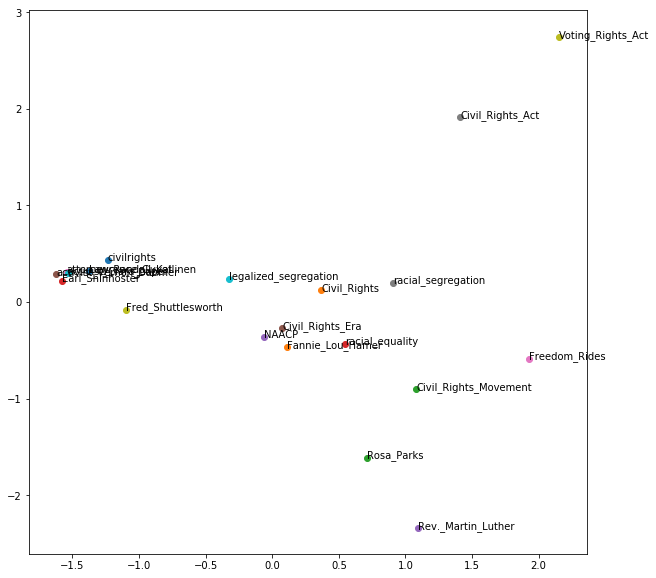

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,10))
for i in range(len(topics_pca)):
    plt.scatter(topics_pca[i,0], topics_pca[i,1])
    plt.annotate(names[i], (topics_pca[i,0], topics_pca[i,1]))
plt.show()

Cool stuff... let's try using t-SNE or maybe SVD (singular value decomposition) as we saw in the prior assignment.

In [152]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2, perplexity = 10)
topics_tsne = tsne.fit_transform(topics)

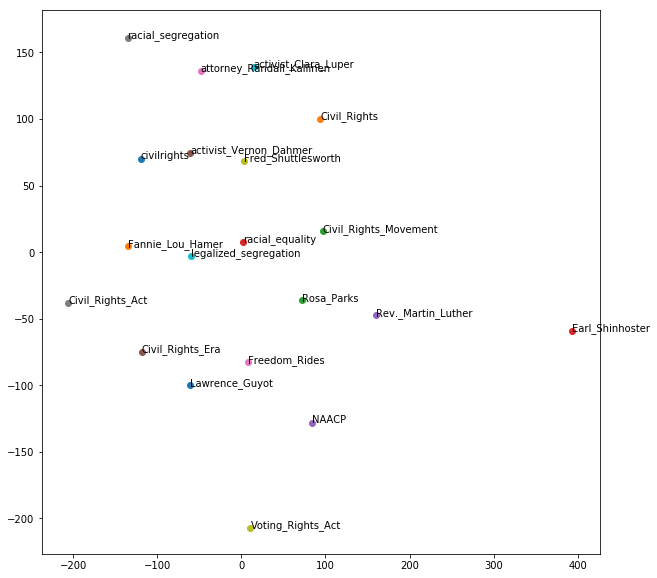

In [153]:
plt.figure(figsize=(10,10))
for i in range(len(topics_tsne)):
    plt.scatter(topics_tsne[i,0], topics_tsne[i,1])
    plt.annotate(names[i], (topics_tsne[i,0], topics_tsne[i,1]))
plt.show()

Lastly, let's see the visualization using SVD - singular value decomposition

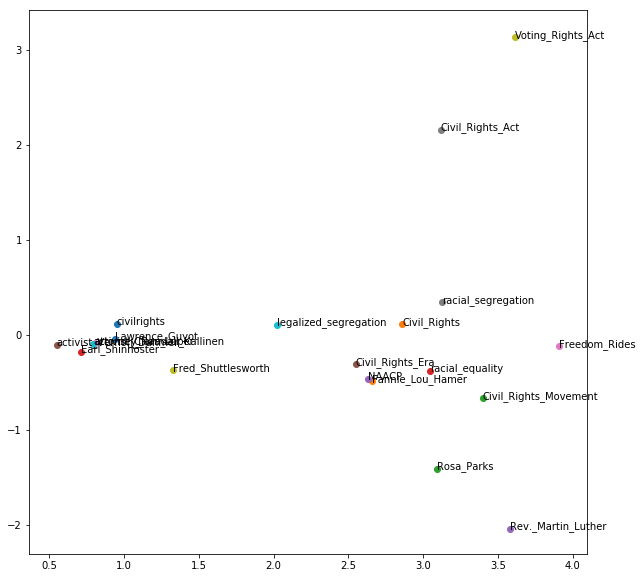

In [154]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components = 2)
topics_svd = svd.fit_transform(topics)

plt.figure(figsize=(10,10))
for i in range(len(topics_svd)):
    plt.scatter(topics_svd[i,0], topics_svd[i,1])
    plt.annotate(names[i], (topics_svd[i,0], topics_svd[i,1]))
plt.show()

Singular Value Decomposition worked in the exact same manner as PCA.